In [1]:
import pandas as pd
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from datasets import load_dataset
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, classification_report, make_scorer, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Embedding, LSTM, Bidirectional
from tensorflow.keras.utils import to_categorical

SEED = np.random.randint(0, 100)

# Task 1 - Data Preparation and Exploration

## Basic dataset information

In [2]:
with open("emotion_dataset.txt", "r") as file:
    lines = file.readlines()

data = []
for line in lines:
    line = line.strip()
    if line:
        try:
            parsed_line = json.loads(line.replace('label:', '"label":'))
            data.append(parsed_line)
        except json.JSONDecodeError as e:
            print(f"Line error: {line} - {e}")

df = pd.DataFrame(data)

print("\nDataset Shape:") # 5000 vrstic in 2 stolpca
print(df.shape)
print("\nDataset Head:")
print(df.head())

print("\nDataset Info:")
df.info()
print("\nMissing Values:") # Ni jih
print(df.isnull().sum())


Dataset Shape:
(5000, 2)

Dataset Head:
                                                text  label
0                            i didnt feel humiliated      0
1  i can go from feeling so hopeless to so damned...      0
2   im grabbing a minute to post i feel greedy wrong      3
3  i am ever feeling nostalgic about the fireplac...      2
4                               i am feeling grouchy      3

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    5000 non-null   object
 1   label   5000 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 78.2+ KB

Missing Values:
text     0
label    0
dtype: int64


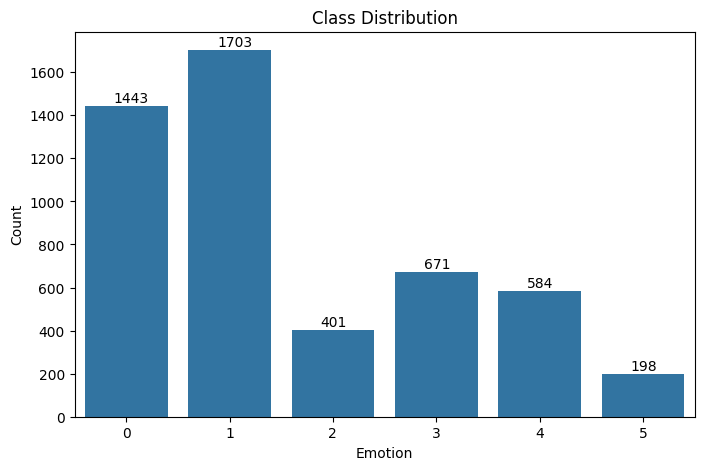

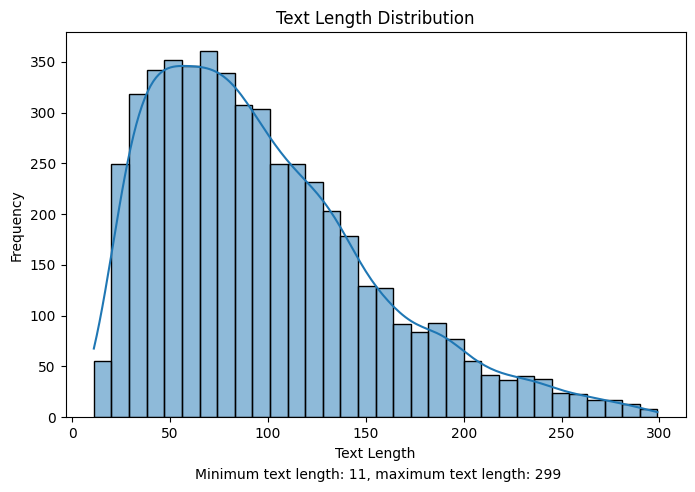

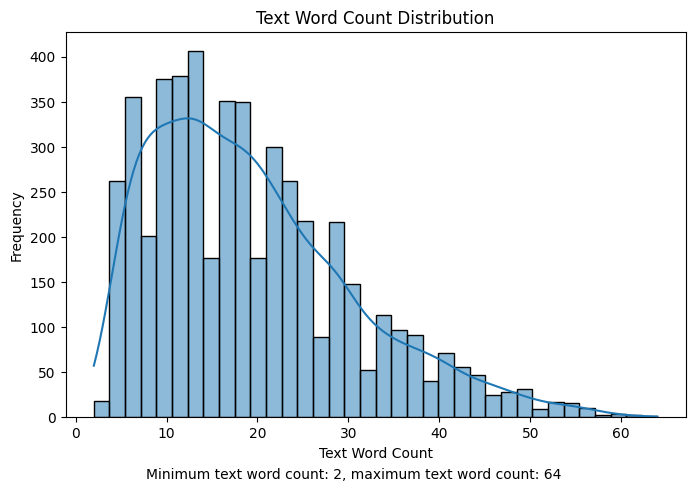

In [3]:
plt.figure(figsize=(8, 5))
sns.countplot(x='label', data=df)
plt.title("Class Distribution")
plt.xlabel("Emotion")
plt.ylabel("Count")
for value, index in zip(df['label'].value_counts(sort=False), df['label'].value_counts(sort=False).index):
    plt.text(index - 0.12, value + 18, str(value))
plt.show()

temp = df.copy()
temp['text_length'] = df['text'].apply(len)
plt.figure(figsize=(8, 5))
sns.histplot(temp['text_length'], kde=True)
plt.title("Text Length Distribution")
plt.xlabel("Text Length")
plt.ylabel("Frequency")
plt.annotate(f"Minimum text length: {temp['text_length'].min()}, maximum text length: {temp['text_length'].max()}",
            xy = (0.8, -0.15),
            xycoords='axes fraction',
            ha="right",
            va="center",
            fontsize=10)
plt.show()

temp['text_word_count'] = temp['text'].apply(lambda x: len(x.split()))
plt.figure(figsize=(8, 5))
sns.histplot(temp['text_word_count'], kde=True)
plt.title("Text Word Count Distribution")
plt.xlabel("Text Word Count")
plt.ylabel("Frequency")
plt.annotate(f"Minimum text word count: {temp['text_word_count'].min()}, maximum text word count: {temp['text_word_count'].max()}",
            xy = (0.8, -0.15),
            xycoords='axes fraction',
            ha='right',
            va="center",
            fontsize=10)
plt.show()
print()

## Splitting dataset into train and test datasets

In [4]:
X = df['text']
y = df['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=SEED, stratify=y)
#X_val, X_test, y_val, y_test, Z_val, Z_test = train_test_split(X_temp, y_temp, Z_temp, test_size=0.5, random_state=42, stratify=y_temp)

print("\nDataset Split:")
print(f"Training Set: {X_train.shape[0]} samples")
print(f"Test Set: {X_test.shape[0]} samples")

df_train = pd.DataFrame({'text': X_train, 'emotion_encoded': y_train})
#df_val = pd.DataFrame({'text': X_val, 'emotion_encoded': y_val, 'tokenized': Z_val})
df_test = pd.DataFrame({'text': X_test, 'emotion_encoded': y_test})

print("\nTraining Set:")
print(df_train.head())


Dataset Split:
Training Set: 3500 samples
Test Set: 1500 samples

Training Set:
                                                   text  emotion_encoded
3531  i feel our children are caught up in these unf...                0
3997  i can see in myself a lot of the older son i m...                1
1809  i continue to spend hrs into not feeling envio...                3
4955  i can spend my life condemning others i feel h...                3
3915                    i feel like i am not very smart                1


## Loading the extended dataset

In [ ]:
# Load whole dataset
ds = load_dataset("dair-ai/emotion", "unsplit")
df1 = pd.DataFrame(ds['train'])

# Remove duplicate rows from whole dataset (training set)
df1_filtered = df1[~df1.apply(tuple, axis=1).isin(df.apply(tuple, axis=1))]
df1_filtered.drop_duplicates(keep='first', inplace=True)

del df1
df1 = df1_filtered
df1.reset_index(drop=True, inplace=True)
x1 = df1['text']
y1 = df1['label']
print("\nExtended Dataset Shape:")
print(df1.shape)

## Text vectorization

In [6]:
# Vectorize text data
vectorizer = TfidfVectorizer(
    lowercase=True,
    stop_words="english",
    max_features=2000,
    ngram_range=(1, 2)
)

X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)
x1_tfidf = vectorizer.transform(x1)

## Functions for confusion matrix and F1 score calculation

In [7]:
def compute_confusion_matrix(correct, predicted):
    correct = np.array(correct, dtype=int)
    predicted = np.array(predicted, dtype=int)

    K = len(np.unique(np.concatenate((correct, predicted))))
    result = np.zeros((K, K), dtype=np.uint32)

    for i in range(len(correct)):
        result[correct[i], predicted[i]] += 1

    return result

def compute_f1_score(correct, predicted):
    confusion_matrix = compute_confusion_matrix(correct, predicted)
    f1_scores = []

    for i in range(confusion_matrix.shape[0]):
        confusion_matrix_bin = np.zeros((2, 2))
        range_without_i = [x for x in range(confusion_matrix.shape[0]) if x != i]

        confusion_matrix_bin[0, 0] += confusion_matrix[i, i]  # True Positives
        confusion_matrix_bin[0, 1] += np.sum(confusion_matrix[range_without_i, i])  # False Negatives
        confusion_matrix_bin[1, 0] += np.sum(confusion_matrix[i, range_without_i])  # False Positives
        confusion_matrix_bin[1, 1] += np.sum(confusion_matrix[range_without_i, range_without_i])  # True Negatives

        if confusion_matrix_bin[0, 0] + confusion_matrix_bin[0, 1] + confusion_matrix_bin[1, 0] > 0:
            f1_scores.append(2 * confusion_matrix_bin[0, 0] / 
                             (2 * confusion_matrix_bin[0, 0] + confusion_matrix_bin[0, 1] + confusion_matrix_bin[1, 0]))
        else:
            f1_scores.append(0)

    return np.mean(np.array(f1_scores))


# Task 2 - Basic Machine Learning

V `params` je zapisana kombinacija parametrov, ki je za mene delovala najboljše. Ko boš testiral naredi for loop in ti naj za vsako kombinacijo izpiše F1 score

In [8]:
# --------------------------------------------------------------------
# 4.1 Decision Tree - mislim da bi moralo biti uredu, sej ma accuracy 0.84
# --------------------------------------------------------------------
tree_params = {
    "max_depth": [None]
}

decision_tree = DecisionTreeClassifier(random_state=SEED)
grid_tree = GridSearchCV(decision_tree, tree_params, scoring="accuracy", cv=5, n_jobs=-1)
grid_tree.fit(X_train_tfidf, y_train)

best_tree = grid_tree.best_estimator_
print("\nBest params for DecisionTree:", grid_tree.best_params_)
y_pred = best_tree.predict(X_test_tfidf)

print("\n=== Decision Tree ===")
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

print("\nF1 Score:")
print(compute_f1_score(y_test, y_pred))
print("\nConfusion Matrix:")
print(compute_confusion_matrix(y_test, y_pred))

y_pred_tree1 = best_tree.predict(x1_tfidf)
print("\n=== Decision Tree on whole dataset ===")
print("Accuracy:", accuracy_score(y1, y_pred_tree1))
print(classification_report(y1, y_pred_tree1))


Best params for DecisionTree: {'max_depth': None}

=== Decision Tree ===
Accuracy: 0.842
              precision    recall  f1-score   support

           0       0.86      0.88      0.87       433
           1       0.85      0.84      0.85       511
           2       0.79      0.78      0.78       120
           3       0.83      0.80      0.81       201
           4       0.82      0.87      0.85       175
           5       0.82      0.77      0.79        60

    accuracy                           0.84      1500
   macro avg       0.83      0.82      0.83      1500
weighted avg       0.84      0.84      0.84      1500


F1 Score:
0.8256317288709581

Confusion Matrix:
[[380  28   7   8  10   0]
 [ 30 431  17  20   8   5]
 [  2  21  93   2   1   1]
 [ 22  13   0 160   6   0]
 [  7   9   0   2 153   4]
 [  0   5   0   0   9  46]]

=== Decision Tree on whole dataset ===
Accuracy: 0.8323202545223692
              precision    recall  f1-score   support

           0       0.88      0.

In [9]:
# --------------------------------------------------------------------
# 4.2 Random Forest
# --------------------------------------------------------------------
rf_params = {
    "max_depth": [None],
    "max_features": ["log2"],
    "n_estimators": [500],
}

random_forest = RandomForestClassifier(random_state=SEED)
grid_rf = GridSearchCV(random_forest, rf_params, scoring="accuracy", cv=5, n_jobs=-1)
grid_rf.fit(X_train_tfidf, y_train)

best_rf = grid_rf.best_estimator_
print("\nBest params for RandomForest:", grid_rf.best_params_)

y_pred_rf = best_rf.predict(X_test_tfidf)

print("\n=== Random Forest ===")
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))

print("\nF1 Score:")
print(compute_f1_score(y_test, y_pred_rf))
print("\nConfusion Matrix:")
print(compute_confusion_matrix(y_test, y_pred_rf))

"""
y_pred_test1 = best_rf.predict(x1_tfidf)
print("\n=== Random Forest on the test dataset ===")
print("Accuracy:", accuracy_score(y2, y_pred_test1))
print(classification_report(y2, y_pred_test1))
"""


Best params for RandomForest: {'max_depth': None, 'max_features': 'log2', 'n_estimators': 500}

=== Random Forest ===
Accuracy: 0.8546666666666667
              precision    recall  f1-score   support

           0       0.88      0.86      0.87       433
           1       0.80      0.93      0.86       511
           2       0.88      0.64      0.74       120
           3       0.91      0.83      0.87       201
           4       0.89      0.82      0.85       175
           5       0.88      0.75      0.81        60

    accuracy                           0.85      1500
   macro avg       0.87      0.81      0.83      1500
weighted avg       0.86      0.85      0.85      1500


F1 Score:
0.8345407352742608

Confusion Matrix:
[[373  44   2   7   7   0]
 [ 17 477   8   4   4   1]
 [  3  38  77   1   0   1]
 [ 20  14   0 166   1   0]
 [  9  13   1   4 144   4]
 [  2   7   0   0   6  45]]


'\ny_pred_test1 = best_rf.predict(x1_tfidf)\nprint("\n=== Random Forest on the test dataset ===")\nprint("Accuracy:", accuracy_score(y2, y_pred_test1))\nprint(classification_report(y2, y_pred_test1))\n'

In [ ]:
# --------------------------------------------------------------------
# 4.3 Bagging Classifier (z decision tree osnovo)
# --------------------------------------------------------------------
bag_params = {
    "n_estimators": [100],
    "max_samples": [1.0],
    "max_features": [1.0],
}
bag_clf = BaggingClassifier(
    estimator=DecisionTreeClassifier(random_state=SEED),
    random_state=SEED,
    n_estimators=100,
    max_features=0.5,
)

grid_bag = GridSearchCV(bag_clf, bag_params, scoring="accuracy", cv=5, n_jobs=-1)
grid_bag.fit(X_train_tfidf, y_train)

best_bag = grid_bag.best_estimator_
print("\nBest params for BaggingClassifier:", grid_bag.best_params_)

y_pred_bag = best_bag.predict(X_test_tfidf)

print("\n=== Bagging Classifier ===")
print("Accuracy:", accuracy_score(y_test, y_pred_bag))
print(classification_report(y_test, y_pred_bag))


Best params for BaggingClassifier: {'max_features': 1.0, 'max_samples': 1.0, 'n_estimators': 100}

=== Bagging Classifier ===
Accuracy: 0.8693333333333333
              precision    recall  f1-score   support

           0       0.88      0.89      0.88       433
           1       0.86      0.90      0.88       511
           2       0.83      0.78      0.80       120
           3       0.89      0.83      0.86       201
           4       0.86      0.86      0.86       175
           5       0.87      0.80      0.83        60

    accuracy                           0.87      1500
   macro avg       0.87      0.84      0.85      1500
weighted avg       0.87      0.87      0.87      1500



In [ ]:
# --------------------------------------------------------------------
# 4.4 Boosting Classifier (Gradient Boosting)
# --------------------------------------------------------------------
boost_params = {
    "n_estimators": [500],
    "learning_rate": [0.15],
    "max_depth": [7],
}

xgb_clf = xgb.XGBClassifier(random_state=SEED)
grid_xgb = GridSearchCV(xgb_clf, boost_params, scoring="accuracy", cv=5, n_jobs=-1)
grid_xgb.fit(X_train_tfidf, y_train)

best_xgb = grid_xgb.best_estimator_
print("\nBest params for XGBClassifier:", grid_xgb.best_params_)

y_pred_xgb = best_xgb.predict(X_test_tfidf)

print("\n=== XGBClassifier (Boosting) ===")
print("Accuracy:", accuracy_score(y_test, y_pred_xgb))
print(classification_report(y_test, y_pred_xgb))


Best params for XGBClassifier: {'learning_rate': 0.15, 'max_depth': 7, 'n_estimators': 500}

=== XGBClassifier (Boosting) ===
Accuracy: 0.8726666666666667
              precision    recall  f1-score   support

           0       0.91      0.87      0.89       433
           1       0.84      0.93      0.88       511
           2       0.87      0.78      0.82       120
           3       0.92      0.81      0.86       201
           4       0.86      0.87      0.87       175
           5       0.84      0.82      0.83        60

    accuracy                           0.87      1500
   macro avg       0.87      0.85      0.86      1500
weighted avg       0.88      0.87      0.87      1500



# Task 3 - Advanced Machine Learning

In [14]:
# ----------------------------------------------------------------------------
# 5.1 LSTM with Pretrained Word Embeddings
# ----------------------------------------------------------------------------
print("\n=== LSTM with Pretrained Word Embeddings ===")

tokenizer = Tokenizer(num_words=20000)
tokenizer.fit_on_texts(X_train)
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

max_seq_length = 100
X_train_padded = pad_sequences(X_train_seq, maxlen=max_seq_length)
X_test_padded = pad_sequences(X_test_seq, maxlen=max_seq_length)

y_train_cat = to_categorical(y_train, num_classes=6)
y_test_cat = to_categorical(y_test, num_classes=6)

# https://nlp.stanford.edu/projects/glove/
embedding_index = {}
with open('glove.6B.100d.txt', encoding='utf8') as f:
    for line in f:
        values = line.split()
        word, vector = values[0], np.asarray(values[1:], dtype='float32')
        embedding_index[word] = vector

embedding_dim = 100
word_index = tokenizer.word_index
print(f"\nFound {len(word_index)} unique tokens.")
num_words = min(20000, len(word_index) + 1)
embedding_matrix = np.zeros((num_words, embedding_dim))

for word, i in word_index.items():
    if i >= 20000:
        continue
    embedding_vector = embedding_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

lstm_model = Sequential([
    Embedding(
        input_dim=num_words,
        output_dim=embedding_dim,
        weights=[embedding_matrix],
        input_length=max_seq_length,
        trainable=False
    ),
    Bidirectional(LSTM(128, return_sequences=True)),
    Dropout(0.3),
    Bidirectional(LSTM(64)),
    Dropout(0.4),
    Dense(6, activation='softmax')
])

lstm_model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

history = lstm_model.fit(
    X_train_padded, y_train_cat,
    epochs=10,
    batch_size=64,
    validation_split=0.1,
    verbose=1
)

y1_pred_lstm = np.argmax(lstm_model.predict(X_test_padded), axis=-1)

print("\nAccuracy (LSTM):", accuracy_score(np.argmax(y_test_cat, axis=-1), y1_pred_lstm))
print(classification_report(np.argmax(y_test_cat, axis=-1), y1_pred_lstm))


=== LSTM with Pretrained Word Embeddings ===

Found 6775 unique tokens.
Epoch 1/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 21s 214ms/step - accuracy: 0.3216 - loss: 1.6200 - val_accuracy: 0.4657 - val_loss: 1.5168
Epoch 2/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 9s 185ms/step - accuracy: 0.4456 - loss: 1.4886 - val_accuracy: 0.4429 - val_loss: 1.4353
Epoch 3/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 9s 186ms/step - accuracy: 0.5096 - loss: 1.3142 - val_accuracy: 0.5257 - val_loss: 1.2643
Epoch 4/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 9s 182ms/step - accuracy: 0.5542 - loss: 1.2106 - val_accuracy: 0.5057 - val_loss: 1.2611
Epoch 5/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 9s 185ms/step - accuracy: 0.5946 - loss: 1.1213 - val_accuracy: 0.5657 - val_loss: 1.1577
Epoch 6/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 9s 186ms/step - accuracy: 0.6357 - loss: 0.9932 - val_accuracy: 0.6257 - val_loss: 1.0412
Epoch 7/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 10s 191ms/step - accuracy: 0.7087 - loss: 0.8369 - val_accuracy: 0.6343 - val_loss: 0.9973
Epoch 8/10
50/50 ━━━━━━━━━━━━

In [15]:
# ----------------------------------------------------------------------------
# 5.2 Ensemble model: XGB + LSTM
# ----------------------------------------------------------------------------
print("\n=== Ensemble model: XGB + LSTM ===")

proba_xgb = best_xgb.predict_proba(X_test_tfidf)
proba_lstm = lstm_model.predict(X_test_padded)

ensemble_proba = (proba_xgb + proba_lstm) / 2.0
ensemble_pred = np.argmax(ensemble_proba, axis=1)

print("Accuracy (Ensemble model: XGB+LSTM):", accuracy_score(y_test, ensemble_pred))
print(classification_report(y_test, ensemble_pred))
print(compute_f1_score(y_test, ensemble_pred))


=== Ensemble model: XGB + LSTM ===
47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step
Accuracy (Ensemble model: XGB+LSTM): 0.8653333333333333
              precision    recall  f1-score   support

           0       0.88      0.92      0.90       433
           1       0.84      0.94      0.89       511
           2       0.88      0.55      0.68       120
           3       0.91      0.86      0.88       201
           4       0.87      0.79      0.83       175
           5       0.81      0.70      0.75        60

    accuracy                           0.87      1500
   macro avg       0.87      0.79      0.82      1500
weighted avg       0.87      0.87      0.86      1500

0.8213374903266167


In [16]:
def get_ordered_params(classifier, paramaters):

    scorer = make_scorer(compute_f1_score, greater_is_better=True)

    grid = GridSearchCV(classifier, paramaters, scoring=scorer, cv=5, n_jobs=-1)
    grid.fit(X_train_tfidf, y_train)

    print("Best params for model:", grid.best_params_)
    print("F1 Score:", grid.best_score_)
    results = pd.DataFrame(grid.cv_results_)
    results.sort_values(by='rank_test_score', inplace=True)

    return results[:]["params"], results[:]["mean_test_score"], grid.best_estimator_

In [17]:
def visualize_results(title, f1_scores, placements):

    f1_scores = np.copy(f1_scores)[placements]

    plt.figure(figsize=(10, 5))
    plt.plot(range(f1_scores.shape[0]), f1_scores)
    for i, score in enumerate(f1_scores):
        plt.scatter(i, score, color='green')
        plt.text(i, score + 0.02, f"{score:.3}", ha='center', color='green')

    plt.xlim(-0.5, f1_scores.shape[0] - 0.5)
    plt.xticks(np.arange(0, f1_scores.shape[0], 1))

    labels = [item.get_text() for item in plt.gca().get_xticklabels()]
    for i in range(len(labels)):
        labels[i] = placements[i]

    plt.gca().set_xticklabels(labels)

    plt.ylim(0, 1)
    plt.yticks(np.arange(0, 1, 0.1))

    plt.ylabel("F1 Score")
    plt.xlabel("Hyperparameter ranking")
    plt.title(title)

    plt.show()

In [18]:
def visualize_confusion_matrix_model(model, data, true, title):
    y_pred = model.predict(data)
    visualize_confusion_matrix(true, y_pred, title)
    
def visualize_confusion_matrix(true, predicted, title):
    display = ConfusionMatrixDisplay(confusion_matrix=compute_confusion_matrix(true, predicted))
    display.plot()
    plt.title(f"{title}")
    plt.annotate(f"F1 Score: {compute_f1_score(true, predicted):.3f}",
                xy = (0.65, -0.15),
                xycoords='axes fraction',
                ha='right',
                va="center",
                fontsize=10)
    plt.show()

In [19]:
params_tree, f1_scores_tree, decision_tree_best = get_ordered_params(decision_tree, {
    "criterion": ["gini", "entropy"],
    "max_depth": [None, 5, 10, 20, 50],
    "min_samples_split": [2, 10, 20, 50, 100],
    "min_samples_leaf": [1, 5, 10, 20, 50],
    "max_features": [None, "sqrt", "log2"]
})

Best params for model: {'criterion': 'gini', 'max_depth': None, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 10}
F1 Score: 0.8307547734845431


In [ ]:
params_rf, f1_scores_rf, random_forest_best = get_ordered_params(random_forest, {
    "n_estimators": [50, 100],
    "criterion": ["gini", "entropy"],
    "max_depth": [None, 10, 20],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
    "max_features": ["sqrt", "log2"]
})

In [26]:
params_bag, f1_scores_bag, bag_clf_best = get_ordered_params(BaggingClassifier(decision_tree_best), {
    "n_estimators": [50, 100],
    "max_samples": [0.5, 0.8, 1.0],
    "max_features": [0.5, 0.8, 1.0],
    "bootstrap": [True, False],
    "random_state": [None, 42, 100] 
})

Best params for model: {'n_estimators': 100, 'max_samples': 0.8, 'max_features': 0.8, 'bootstrap': True, 'random_state': 42}
F1 Score: 0.8539528404126369


In [ ]:
params_xgb, f1_scores_xgb, xgb_clf_best = get_ordered_params(xgb_clf, {
    "n_estimators": [25, 40],
    "learning_rate": [0.01, 0.1, 0.2],
    "max_depth": [3, 5, 7],
    "min_child_weight": [1, 3, 5],
    "subsample": [0.8, 1.0],
    "colsample_bytree": [0.8, 1.0],
    "gamma": [0, 0.1, 0.2]
})

# Task 4 - Results and Report

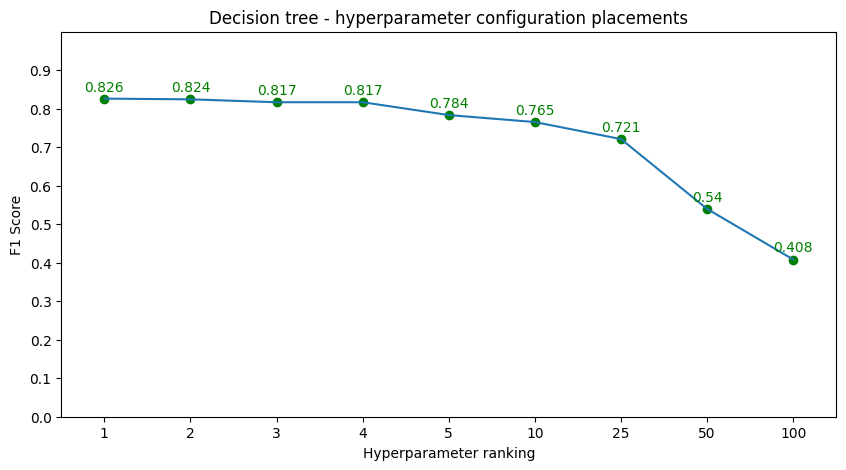

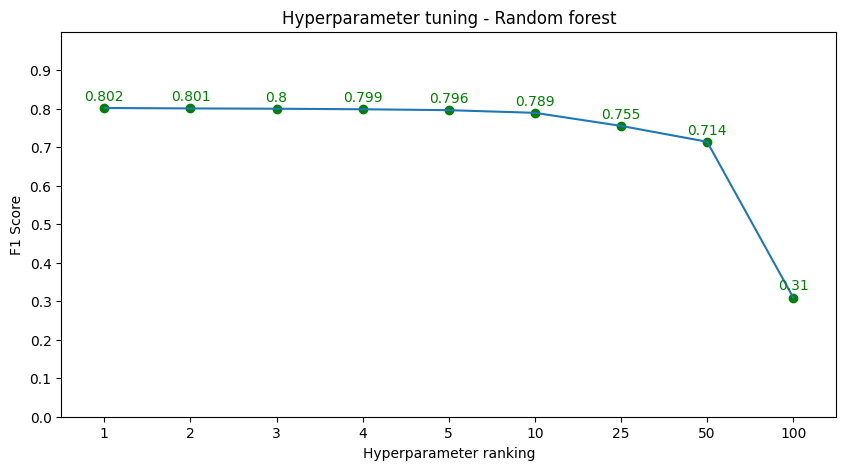

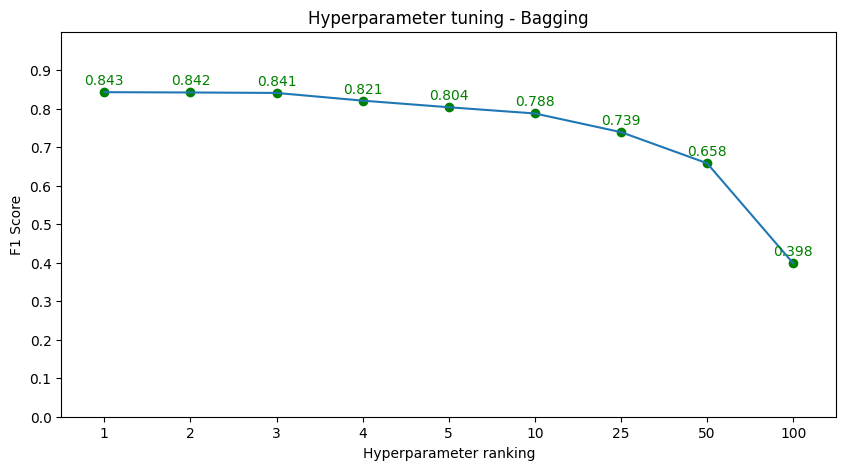

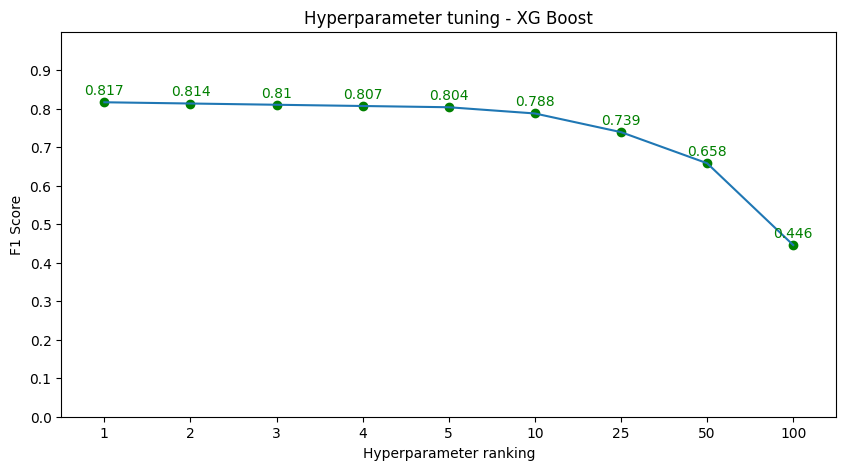

In [32]:
placements = [1, 2, 3, 4, 5, 10, 25, 50, 100]

visualize_results("Decision tree - hyperparameter configuration placements", f1_scores_tree.to_numpy(), placements)
#print(f"Hyperparamaters:\n{params_tree.to_numpy()[placements]}")
visualize_results("Hyperparameter tuning - Random forest", f1_scores_rf, placements)
#print(f"Hyperparamaters:\n{params_rf.to_numpy()[placements]}")
visualize_results("Hyperparameter tuning - Bagging", f1_scores_bag, placements)
#print(f"Hyperparamaters:\n{params_bag.to_numpy()[placements]}")
visualize_results("Hyperparameter tuning - XG Boost", f1_scores_xgb, placements)
#print(f"Hyperparamaters:\n{params_xgb.to_numpy()[placements]}")

## Basic dataset

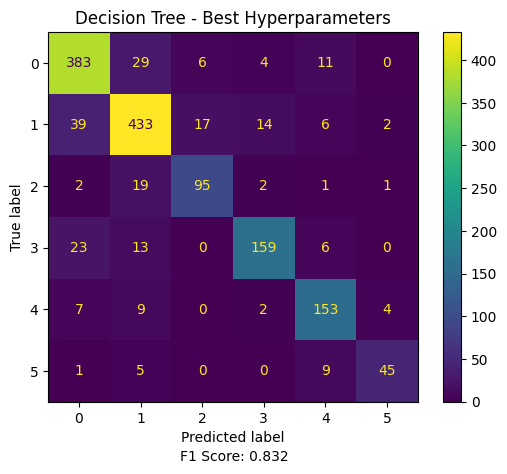

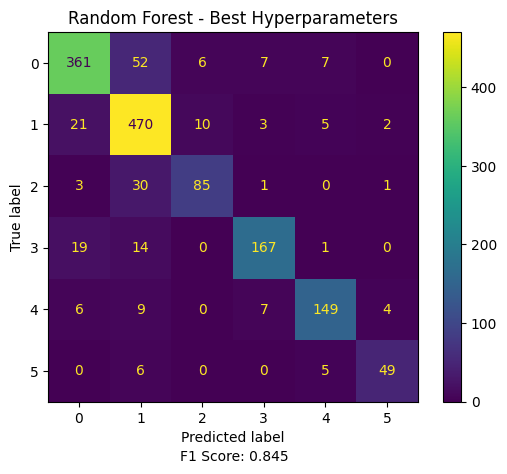

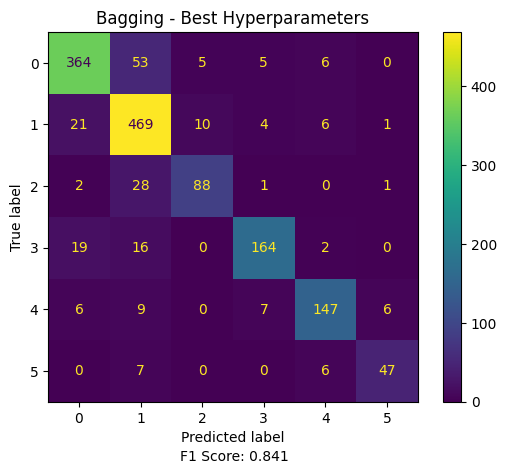

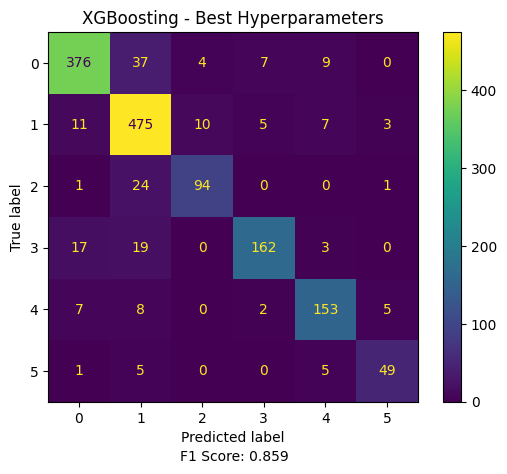

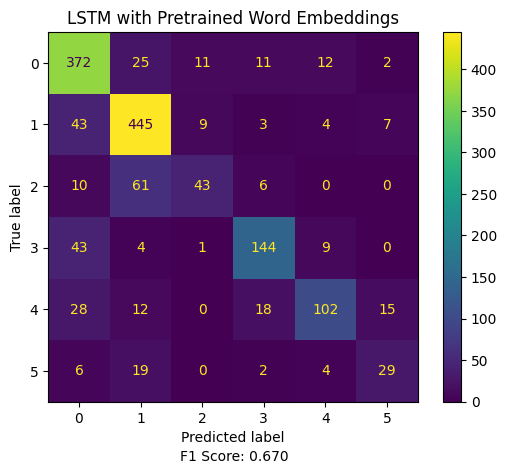

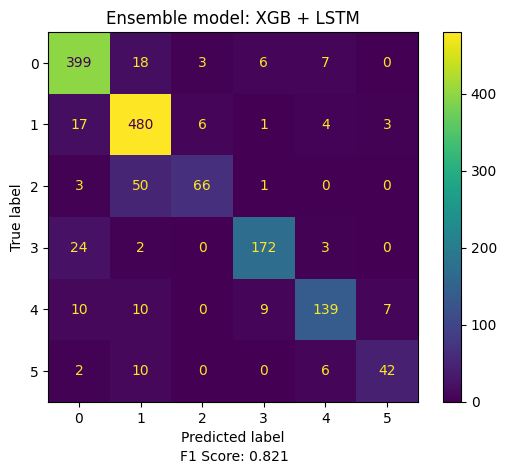

In [39]:
visualize_confusion_matrix_model(decision_tree_best, X_test_tfidf, y_test, "Decision Tree - Best Hyperparameters")
#print(f"Paramaters: {params_tree[0]}")
visualize_confusion_matrix_model(random_forest_best, X_test_tfidf, y_test, "Random Forest - Best Hyperparameters")
#print(f"Paramaters: {params_rf[0]}")
visualize_confusion_matrix_model(bag_clf_best, X_test_tfidf, y_test, "Bagging - Best Hyperparameters")
#print(f"Paramaters: {params_bag[0]}")
visualize_confusion_matrix_model(xgb_clf_best, X_test_tfidf, y_test, "XGBoosting - Best Hyperparameters")
#print(f"Paramaters: {params_xgb.to_numpy()[0]}")
visualize_confusion_matrix(np.argmax(y_test_cat, axis=-1), y1_pred_lstm, "LSTM with Pretrained Word Embeddings")
visualize_confusion_matrix(y_test, ensemble_pred, "Ensemble model: XGB + LSTM")

## Extended dataset

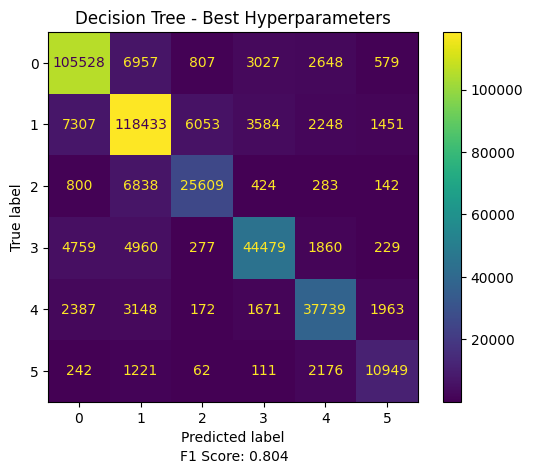

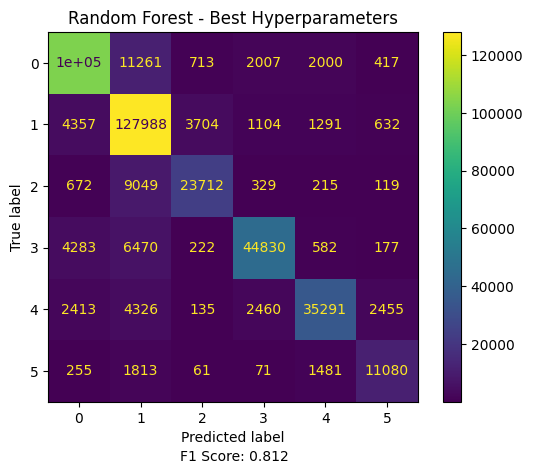

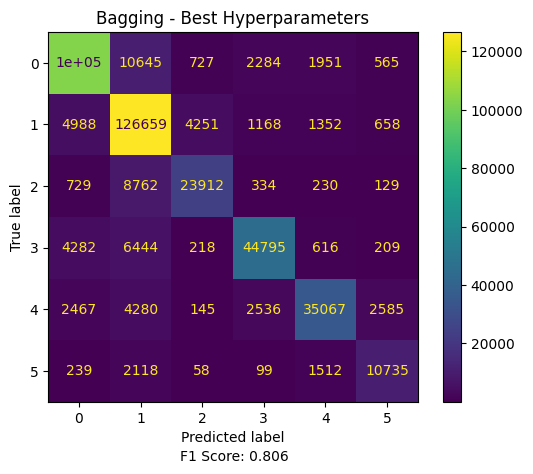

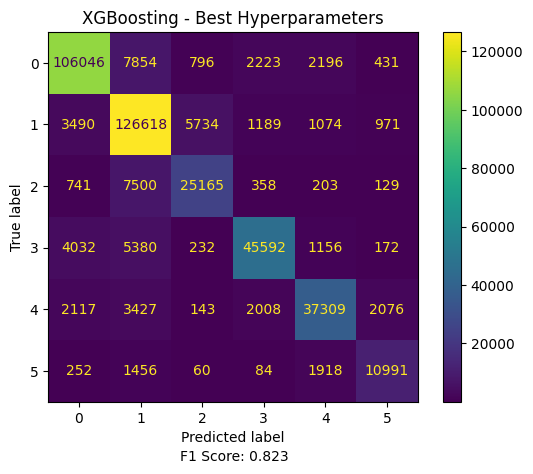

In [45]:
visualize_confusion_matrix_model(decision_tree_best, x1_tfidf, y1, "Decision Tree - Best Hyperparameters")
#print(f"Paramaters: {params_tree[0]}")
visualize_confusion_matrix_model(random_forest_best, x1_tfidf, y1, "Random Forest - Best Hyperparameters")
#print(f"Paramaters: {params_rf[0]}")
visualize_confusion_matrix_model(bag_clf_best, x1_tfidf, y1, "Bagging - Best Hyperparameters")
#print(f"Paramaters: {params_bag.to_numpy()[0]}")
visualize_confusion_matrix_model(xgb_clf_best, x1_tfidf, y1, "XGBoosting - Best Hyperparameters")
#print(f"Paramaters: {params_xgb.to_numpy()[0]}")

In [337]:
x1_seq = tokenizer.texts_to_sequences(x1)
x1_padded = pad_sequences(x1_seq, maxlen=max_seq_length)
y1_cat = to_categorical(y1, num_classes=6)

y1_proba_lstm = lstm_model.predict(x1_padded)
y1_pred_lstm = np.argmax(y1_proba_lstm, axis=-1)

12848/12848 ━━━━━━━━━━━━━━━━━━━━ 813s 63ms/step


In [338]:
y1_proba_xgb = best_xgb.predict_proba(x1_tfidf)

y1_ensemble_proba = (y1_proba_xgb + y1_proba_lstm) / 2.0
y1_ensemble_pred = np.argmax(y1_ensemble_proba, axis=1)

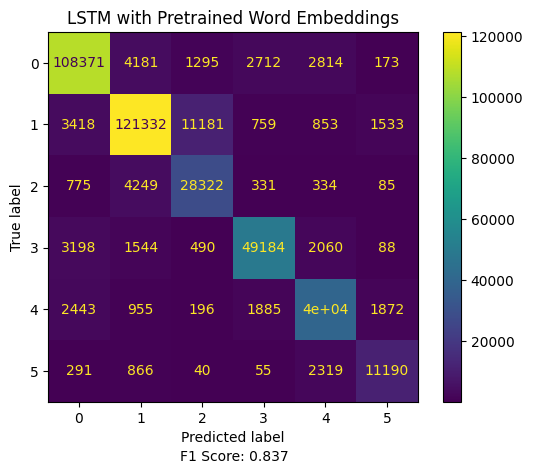

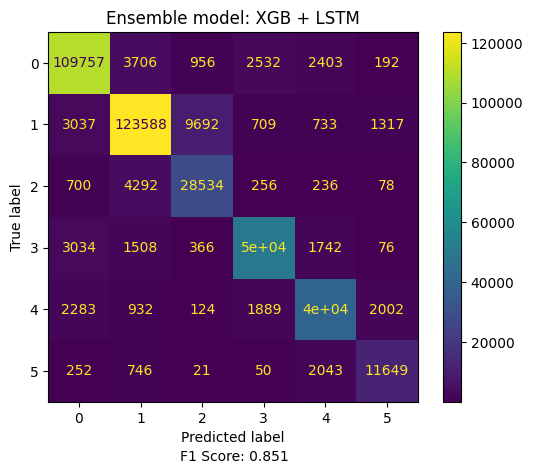

In [340]:
visualize_confusion_matrix(np.argmax(y1_cat, axis=-1), y1_pred_lstm, "LSTM with Pretrained Word Embeddings")
visualize_confusion_matrix(y1, y1_ensemble_pred, "Ensemble model: XGB + LSTM")

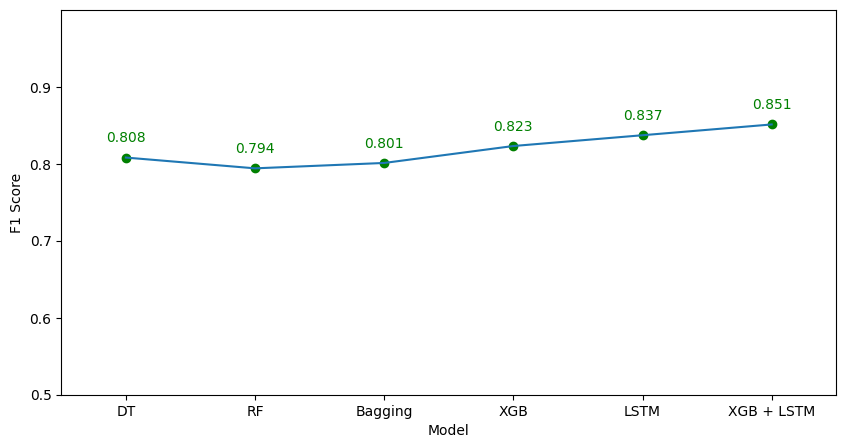

In [50]:
plt.figure(figsize=(10, 5))
plt.plot(range(6), [0.808, 0.794, 0.801, 0.823, 0.837, 0.851])
for i, score in enumerate([0.808, 0.794, 0.801, 0.823, 0.837, 0.851]):
    plt.scatter(i, score, color='green')
    plt.text(i, score + 0.02, f"{score:.3}", ha='center', color='green')

plt.xlim(-0.5, 5.5)
plt.xticks(np.arange(0, 6, 1))

labels = [item.get_text() for item in plt.gca().get_xticklabels()]
text_labels = ["DT", "RF", "Bagging", "XGB", "LSTM", "XGB + LSTM"]
for i in range(len(labels)):
    labels[i] = text_labels[i]

plt.gca().set_xticklabels(labels)

plt.ylim(0.5, 1)
plt.yticks(np.arange(0.5, 1, 0.1))

plt.ylabel("F1 Score")
plt.xlabel("Model")
plt.title("")

plt.show()

# Conclusion

The analysis demonstrates a clear distinction in performance between basic and advanced models. The basic models, including decision trees, random forests, bagging, and XGBoost, achieved an F1 score of approximately 0.8, indicating solid but limited effectiveness in classification. In contrast, the advanced models, particularly the LSTM-based neural network leveraging pretrained word embeddings, achieved a comparable performance around 0.8 as well, highlighting the potential of deep learning in handling text-based tasks.

While both approaches yielded similar results in this case, advanced models provide greater flexibility and scalability for future improvements, particularly with fine-tuning and larger datasets. Hyperparameter tuning and proper preprocessing played a crucial role in maximizing the performance of all models.